<a href="https://colab.research.google.com/github/olganikolaeva-hub/ml_in_business/blob/main/Homework2_clustering_lda_model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Homework2. Профилирование пользователей. Сегментация: unsupervised learning (clustering, LDA/ARTM), supervised
(multi/binary classification)

In [1]:
#Задача заключается в следующем: сегментировать новости методом кластерного анализа, т.е. без разметки новостей по темам с помощью методов тематического моделирования.
#Затем понять, какие темы новостей повлияли на отток клиентов, исходя из последних прочитанных новостей и бинарного таргета [0,1] - пользователь остался/ушел.

import os
import pandas as pd

#Импортируем doc_id и текст новости title (массив из 27 тыс. новостей) в датафрейм news:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR" -O articles.csv && rm -rf /tmp/cookies.txt 
news = pd.read_csv("articles.csv")
news.head()

--2022-06-08 06:11:47--  https://docs.google.com/uc?export=download&confirm=t&id=1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR
Resolving docs.google.com (docs.google.com)... 108.177.111.101, 108.177.111.139, 108.177.111.113, ...
Connecting to docs.google.com (docs.google.com)|108.177.111.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uk3bu1eclatud59nic6bdd1t3svif428/1654668675000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download [following]
--2022-06-08 06:11:47--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/uk3bu1eclatud59nic6bdd1t3svif428/1654668675000/14904333240138417226/*/1zrdSHN2tq_Hj3YdbwlM3jk87Oct42XpR?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-

,doc_id,title
0,6,Заместитель председателяnправительства РФnСерг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...
4,4899,Решением попечительского совета владивостокско...


In [2]:
news.shape

(27000, 2)

In [4]:
#Пример новости:
news.iloc[0,1]

'Заместитель председателяnправительства РФnСергейnИвановnизбран председателем советаnПБК ЦСКАn. Как сообщаетnпресс-службаnармейцев, такое решение было единогласно принято на первом заседании совета клуба. Основной функцией этого органа будет обсуждение текущего состояния, планирование и утверждение стратегии развития клуба на ближайшую перспективу.nnВ состав совета вошли:nГеоргий Полтавченкоn(полномочный представитель президента в Центральном федеральном округе),nАлексей Седовn(генерал-полковник, начальник службы по защите конституционного строя и борьбе с терроризмомnФСБ РФn),nАлександр Новакn(заместитель министра финансов РФ),nВячеслав Полтавцевn(заместитель генерального директора, руководитель блока по взаимодействию с органами власти, социальной и корпоративной политикиnГМК «Норильский никель»n),nЛеонид Исаковичn(генеральный директор ООО «УК «Спортивные проекты»),nОльга Плешаковаn(генеральный директорn«Трансаэро»n),nАлександр Провоторовn, (генеральный директорnОАО «Ростелеком»n), А

In [6]:
#Загрузим юзеров, которые читали данные новости: 8 тыс. уникальных юзеров uid к которым привязан список идентификаторов статей, в датафрейм users::
!wget 'https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a' -O users_articles.csv
users = pd.read_csv("users_articles.csv")
users.shape

--2022-06-08 06:14:49--  https://drive.google.com/uc?export=download&id=1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a
Resolving drive.google.com (drive.google.com)... 142.250.136.101, 142.250.136.139, 142.250.136.102, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ge8tr3aujfbriti8rrd9gk1c31as3bor/1654668825000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download [following]
--2022-06-08 06:14:49--  https://doc-04-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/ge8tr3aujfbriti8rrd9gk1c31as3bor/1654668825000/14904333240138417226/*/1Q97K9eGrvpbS4ut5CphZa--gJDRqQp2a?e=download
Resolving doc-04-c0-docs.googleusercontent.com (doc-04-c0-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-04-c0-docs.googleusercontent.com (doc-04-c0

(8000, 2)

In [7]:
users.head()

,uid,articles
0,u105138,"[293672, 293328, 293001, 293622, 293126, 1852]"
1,u108690,"[3405, 1739, 2972, 1158, 1599, 322665]"
2,u108339,"[1845, 2009, 2356, 1424, 2939, 323389]"
3,u101138,"[5933, 6186, 5055, 6977, 5206, 488389]"
4,u108248,"[707, 1144, 2532, 2928, 3133, 324592]"


#### Получим векторное представление пользователей на основе прочитанным ими новостей и самих новостей

In [8]:
#Необходимые библиотеки для предобработки текстов:
!pip install razdel pymorphy2 pyLDAvis

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 55 kB 2.6 MB/s 
     |████████████████████████████████| 1.7 MB 11.5 MB/s 
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
    Preparing wheel metadata ... done
     |████████████████████████████████| 8.2 MB 36.5 MB/s 
  Created wheel for pyLDAvis: filename=pyLDAvis-3.3.1-py2.py3-none-any.whl size=136898 sha256=7a0e93ddf55233d3dd69fba946cfb34ddae70d64c0f8a8c4ec02709ea41d92cc
  Stored in directory: /root/.cache/pip/wheels/c9/21/f6/17bcf2667e8a68532ba2fbf6d5c72fdf4c7f7d9abfa4852d2f
Successfully built pyLDAvis


In [9]:
# предобработка текстов
import re
import numpy as np
from gensim.corpora.dictionary import Dictionary
from razdel import tokenize  # сегментация русскоязычного текста на токены и предложения https://github.com/natasha/razdel
import pymorphy2  # Морфологический анализатор

In [10]:
#Загрузим стоп-слова, по которым не хотим вести статистику в предложениях: предлоги, местоимения и прочее:
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [11]:
stopword_ru = stopwords.words('russian')
print(len(stopword_ru))

151


In [12]:
#Загружаем дополнительные стоп-слова в список стоп слов из файла stopwords.txt:
!wget 'https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c' -O stopwords.txt
with open('stopwords.txt') as f:
    additional_stopwords = [w.strip() for w in f.readlines() if w]
    
stopword_ru += additional_stopwords
stopword_ru[:5]

--2022-06-08 06:17:24--  https://drive.google.com/uc?export=download&id=17wVn5YPpMjHToctGgff_KfSeWcIIlf7c
Resolving drive.google.com (drive.google.com)... 142.250.136.101, 142.250.136.139, 142.250.136.113, ...
Connecting to drive.google.com (drive.google.com)|142.250.136.101|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nu5lihtcpu58o4c1c7i6aja16gt2ophr/1654668975000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download [following]
--2022-06-08 06:17:24--  https://doc-0s-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/nu5lihtcpu58o4c1c7i6aja16gt2ophr/1654668975000/14904333240138417226/*/17wVn5YPpMjHToctGgff_KfSeWcIIlf7c?e=download
Resolving doc-0s-c0-docs.googleusercontent.com (doc-0s-c0-docs.googleusercontent.com)... 142.250.128.132, 2607:f8b0:4001:c32::84
Connecting to doc-0s-c0-docs.googleusercontent.com (doc-0s-c0

['и', 'в', 'во', 'не', 'что']

In [13]:
#Создаем функцию, очищающую текст от лишних пробелов, переносов и так далее:
def clean_text(text):
    '''
    очистка текста
    
    на выходе очищеный текст
    '''
    if not isinstance(text, str):
        text = str(text)
    
    text = text.lower()
    text = text.strip('\n').strip('\r').strip('\t')
    text = re.sub("-\s\r\n\|-\s\r\n|\r\n", '', str(text))

    text = re.sub("[0-9]|[-—.,:;_%©«»?*!@#№$^•·&()]|[+=]|[[]|[]]|[/]|", '', text)
    text = re.sub(r"\r\n\t|\n|\\s|\r\t|\\n", ' ', text)
    text = re.sub(r'[\xad]|[\s+]', ' ', text.strip())
    text = re.sub('n', ' ', text)
    
    return text

In [14]:
#Создаем функцию, которая делает морфологический анализ входящих слов статьи:
cache = {}
morph = pymorphy2.MorphAnalyzer()

def lemmatization(text):    
    '''
    лемматизация
        [0] если зашел тип не `str` делаем его `str`
        [1] токенизация предложения через razdel
        [2] проверка есть ли в начале слова '-'
        [3] проверка токена с одного символа
        [4] проверка есть ли данное слово в кэше
        [5] лемматизация слова
        [6] проверка на стоп-слова

    на выходе лист лемматизированых токенов
    '''

    # [0]
    if not isinstance(text, str):
        text = str(text)
    
    # [1]
    #сегментируем статью на токены-слова:
    tokens = list(tokenize(text))
    words = [_.text for _ in tokens]

    words_lem = []
    for w in words:
        if w[0] == '-': # [2]
            w = w[1:]
        if len(w) > 1: # [3]
            if w in cache: # [4]
                words_lem.append(cache[w])
            else: # [5]
                #каждое слово переводим в нормальную форму
                temp_cach = cache[w] = morph.parse(w)[0].normal_form
                words_lem.append(temp_cach)
    
    words_lem_without_stopwords = [i for i in words_lem if not i in stopword_ru] # [6]
    
    return words_lem_without_stopwords

In [15]:
#Пример: 
morph.parse('сбегали')[0].normal_form

'сбегать'

In [16]:
#Запускаем очистку текста:
%%time
from tqdm import tqdm
tqdm.pandas()

news['title_clean'] = news['title'].progress_apply(lambda x: clean_text(x))

  0%|          | 0/27000 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:15: FutureWarning: Possible nested set at position 39
  from ipykernel import kernelapp as app
100%|██████████| 27000/27000 [00:35<00:00, 761.76it/s] 

CPU times: user 30.4 s, sys: 1.38 s, total: 31.8 s
Wall time: 35.5 s


In [17]:
news.head()

,doc_id,title,title_clean
0,6,Заместитель председателяnправительства РФnСерг...,заместитель председателя правительства рф серг...
1,4896,Матч 1/16 финала Кубка России по футболу был п...,матч финала кубка россии по футболу был приос...
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...,форвард авангарда томаш заборский прокомментир...
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...,главный тренер кубани юрий красножан прокоммен...
4,4899,Решением попечительского совета владивостокско...,решением попечительского совета владивостокско...


In [18]:
news['title_clean'] = news['title_clean'].progress_apply(lambda x: lemmatization(x))

100%|██████████| 27000/27000 [04:37<00:00, 97.45it/s] 


In [19]:
news.head()

,doc_id,title,title_clean
0,6,Заместитель председателяnправительства РФnСерг...,"[заместитель, председатель, правительство, рф,..."
1,4896,Матч 1/16 финала Кубка России по футболу был п...,"[матч, финал, кубок, россия, футбол, приостано..."
2,4897,Форвард «Авангарда» Томаш Заборский прокоммент...,"[форвард, авангард, томаш, заборский, прокомме..."
3,4898,Главный тренер «Кубани» Юрий Красножан прокомм...,"[главный, тренер, кубань, юрий, красножанин, п..."
4,4899,Решением попечительского совета владивостокско...,"[решение, попечительский, совет, владивостокск..."


In [20]:
#Создаем список наших текстов (список из списка слов, соответствеющих статьям, которые мы анализируем):
texts = list(news['title_clean'].values)

In [22]:
#Создаем корпус из списка с текстом: common_corpus - это словарь слов для каждого предложения для всего корпуса документов с частотой встречаемости слов:
common_dictionary = Dictionary(texts)
common_corpus = [common_dictionary.doc2bow(text) for text in texts]
common_dictionary

Запускаем обучение

In [24]:
N_topic = 20

from gensim.models import LdaModel

In [25]:
%%time
# Обучаем модель на корпусе, для этого модели LDA надо подать на вход корпус слов, словарь и кол-во тем - кол-во кластеров:
lda = LdaModel(common_corpus, num_topics=N_topic, id2word=common_dictionary)#, passes=10)

CPU times: user 48 s, sys: 22.5 s, total: 1min 10s
Wall time: 45.8 s


In [27]:
#Посмотрим, можем ли мы интерпретировать темы:
x = lda.show_topics(num_topics=N_topic, num_words=5, formatted=False)
for tp in x:
  print(tp)

(0, [('выделить', 0.013581275), ('вирус', 0.012979923), ('миллиард', 0.011819698), ('достигать', 0.010724716), ('доллар', 0.010464969)])
(1, [('ребёнок', 0.02074042), ('тыс', 0.010164236), ('мужчина', 0.010037573), ('летний', 0.009083992), ('женщина', 0.007853806)])
(2, [('заболевание', 0.01284413), ('восток', 0.012507953), ('врач', 0.011784715), ('обнаружить', 0.009600755), ('общество', 0.008127203)])
(3, [('население', 0.017239543), ('рак', 0.010722523), ('топливо', 0.006760257), ('производитель', 0.0066144783), ('снизиться', 0.0063665346)])
(4, [('миссия', 0.014406612), ('вицепремьер', 0.011274074), ('парламент', 0.010745931), ('государство', 0.010184465), ('виза', 0.008310648)])
(5, [('самолёт', 0.011492142), ('руб', 0.009726673), ('армия', 0.008253082), ('тыс', 0.007347316), ('газпром', 0.007321465)])
(6, [('млрд', 0.01370237), ('рубль', 0.01109063), ('цена', 0.010210606), ('гражданин', 0.008967989), ('россия', 0.007861105)])
(7, [('пострадать', 0.009517942), ('данные', 0.00901753

In [28]:
topics_words = [(tp[0], [wd[0] for wd in tp[1]]) for tp in x]

# Печатаем только слова
for topic, words in topics_words:
    print(f"topic_{topic}: " + " ".join(words))

topic_0: выделить вирус миллиард достигать доллар
topic_1: ребёнок тыс мужчина летний женщина
topic_2: заболевание восток врач обнаружить общество
topic_3: население рак топливо производитель снизиться
topic_4: миссия вицепремьер парламент государство виза
topic_5: самолёт руб армия тыс газпром
topic_6: млрд рубль цена гражданин россия
topic_7: пострадать данные житель пассажир местный
topic_8: учёный космический наука спутник животное
topic_9: россия газ российский статья агентство
topic_10: исследование млн автор жизнь солнечный
topic_11: сша нефть самолёт новый эксперт
topic_12: всё район первый очень большой
topic_13: земля тело произойти взрыв дом
topic_14: россия научный исследование всё вопрос
topic_15: украина украинский пациент кровь болезнь
topic_16: px вероятно озеро смерть adce
topic_17: журнал фонд место новый первый
topic_18: военный погибнуть американский война сша
topic_19: ракета исследователь проверка университет обнаружить


In [30]:
#Напишем функцию, которая будет нам возвращать векторное представление новости-текста на основе построенной модели lda, в виде набора тем и принадлежности новости
#к теме:
def get_lda_vector(lda, text):
    unseen_doc = common_dictionary.doc2bow(text)
    lda_tuple = lda[unseen_doc]

    not_null_topics = dict(zip([i[0] for i in lda_tuple], [i[1] for i in lda_tuple]))

    output_vector = []
    for i in range(N_topic):
        if i not in not_null_topics:
            output_vector.append(0)
        else:
            output_vector.append(not_null_topics[i])
    return np.array(output_vector)

In [32]:
%%time
topic_matrix = pd.DataFrame([get_lda_vector(lda, text) for text in news['title_clean'].values])
topic_matrix.columns = [f'topic_{i}' for i in range(N_topic)]
topic_matrix['doc_id'] = news['doc_id'].values
topic_matrix = topic_matrix[['doc_id']+[f'topic_{i}' for i in range(N_topic)]]
topic_matrix.head(5)

CPU times: user 39.7 s, sys: 21 s, total: 1min
Wall time: 44.7 s


In [33]:
#Получили для каждого документа переменные, которые описывают его по темам:
topic_matrix.head(5)

,doc_id,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,6,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.10579,0.0,0.000000,0.255883,0.432999,0.000000,0.198311,0.0,0.0,0.0
1,4896,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.421390,0.556659,0.000000,0.000000,0.000000,0.0,0.0,0.0
2,4897,0.00000,0.090991,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.886509,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
3,4898,0.00000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.577827,0.000000,0.000000,0.382993,0.000000,0.0,0.0,0.0
4,4899,0.50668,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.00000,0.0,0.080390,0.039318,0.351990,0.000000,0.000000,0.0,0.0,0.0


Следующий шаг - векторные представления пользователей на основе просмотренных ими новостей

In [34]:
#Создадим словарь с ключами - идентификаторами статьи и значениями - вероятностями принадлежности темам:
doc_dict = dict(zip(topic_matrix['doc_id'].values, topic_matrix[[f'topic_{i}' for i in range(N_topic)]].values))
doc_dict[6]

array([0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.10578973, 0.        , 0.        , 0.2558831 , 0.43299901,
       0.        , 0.1983106 , 0.        , 0.        , 0.        ])

In [35]:
#Создадим функцию, которая для юзера на основе просмотренных новостей будет фиксировать его медианную и максимальную принадлежность к теме:
def get_user_embedding_median(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.median(user_vector, 0)  # можно не среднее
    return user_vector

def get_user_embedding_max(user_articles_list, doc_dict):
    user_articles_list = eval(user_articles_list)
    user_vector = np.array([doc_dict[doc_id] for doc_id in user_articles_list])
    # print(user_vector)
    user_vector = np.max(user_vector, 0)  # можно не среднее
    return user_vector

Теперь получим эмбединги для всех пользователей и проверим их качество на конкретной downstream-задаче

In [36]:
%%time
user_embeddings_median = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_median(x, doc_dict))])
user_embeddings_median.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_median['uid'] = users['uid'].values
user_embeddings_median = user_embeddings_median[['uid']+[f'topic_{i}' for i in range(N_topic)]]
user_embeddings_median.head(3)

CPU times: user 1.06 s, sys: 8.8 ms, total: 1.07 s
Wall time: 1.11 s


In [37]:
user_embeddings_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.000000,0.000000,0.000000,0.0,0.025774,0.047448,0.162017,0.0,...,0.0,0.0,0.012711,0.016150,0.072916,0.023663,0.0,0.014243,0.000000,0.0
1,u108690,0.005972,0.034011,0.009155,0.078640,0.0,0.015087,0.043262,0.020459,0.0,...,0.0,0.0,0.055187,0.010078,0.282713,0.082362,0.0,0.006458,0.006828,0.0
2,u108339,0.006670,0.006334,0.020301,0.063567,0.0,0.058164,0.014782,0.174679,0.0,...,0.0,0.0,0.030358,0.182756,0.193567,0.017325,0.0,0.000000,0.011873,0.0


In [38]:
%%time
user_embeddings_max = pd.DataFrame([i for i in users['articles'].apply(lambda x: get_user_embedding_max(x, doc_dict))])
user_embeddings_max.columns = [f'topic_{i}' for i in range(N_topic)]
user_embeddings_max['uid'] = users['uid'].values
user_embeddings_max = user_embeddings_max[['uid']+[f'topic_{i}' for i in range(N_topic)]]

CPU times: user 336 ms, sys: 3.44 ms, total: 339 ms
Wall time: 353 ms


In [39]:
user_embeddings_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_10,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19
0,u105138,0.000000,0.567992,0.000000,0.130559,0.015482,0.138745,0.273519,0.580691,0.072849,...,0.417055,0.000000,0.080332,0.206525,0.274564,0.390277,0.043115,0.437829,0.071730,0.000000
1,u108690,0.020274,0.111617,0.059113,0.237063,0.019019,0.023902,0.184499,0.261363,0.058647,...,0.066517,0.281162,0.145172,0.241638,0.324962,0.387050,0.000000,0.026622,0.143790,0.014569
2,u108339,0.083760,0.018581,0.197005,0.119949,0.075547,0.115410,0.190062,0.249782,0.050200,...,0.015273,0.165210,0.084357,0.328638,0.275377,0.049500,0.016260,0.104689,0.072959,0.018275


Загрузим разметку юзеров и обучим модель

In [40]:
!wget 'https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK' -O users_churn.csv
target = pd.read_csv("users_churn.csv")
target.head(3)

--2022-06-08 08:08:47--  https://drive.google.com/uc?export=download&id=1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK
Resolving drive.google.com (drive.google.com)... 142.250.125.138, 142.250.125.101, 142.250.125.100, ...
Connecting to drive.google.com (drive.google.com)|142.250.125.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kgi1h1nps78f0c6v48pej68nc2uf7sth/1654675725000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download [following]
--2022-06-08 08:08:48--  https://doc-0k-c0-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/kgi1h1nps78f0c6v48pej68nc2uf7sth/1654675725000/14904333240138417226/*/1nWKteQgEr9Rl8CwTRY7N2f7igevNH7oK?e=download
Resolving doc-0k-c0-docs.googleusercontent.com (doc-0k-c0-docs.googleusercontent.com)... 142.250.103.132, 2607:f8b0:4001:c2b::84
Connecting to doc-0k-c0-docs.googleusercontent.com (doc-0k-c0

,uid,churn
0,u107120,0
1,u102277,0
2,u102444,0


In [41]:
target.shape

(8000, 2)

In [42]:
X_median = pd.merge(user_embeddings_median, target, 'left')
X_median.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.000000,0.000000,0.000000,0.0,0.025774,0.047448,0.162017,0.0,...,0.0,0.012711,0.016150,0.072916,0.023663,0.0,0.014243,0.000000,0.0,0
1,u108690,0.005972,0.034011,0.009155,0.078640,0.0,0.015087,0.043262,0.020459,0.0,...,0.0,0.055187,0.010078,0.282713,0.082362,0.0,0.006458,0.006828,0.0,1
2,u108339,0.006670,0.006334,0.020301,0.063567,0.0,0.058164,0.014782,0.174679,0.0,...,0.0,0.030358,0.182756,0.193567,0.017325,0.0,0.000000,0.011873,0.0,1


In [43]:
X_max = pd.merge(user_embeddings_max, target, 'left')
X_max.head(3)

,uid,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7,topic_8,...,topic_11,topic_12,topic_13,topic_14,topic_15,topic_16,topic_17,topic_18,topic_19,churn
0,u105138,0.000000,0.567992,0.000000,0.130559,0.015482,0.138745,0.273519,0.580691,0.072849,...,0.000000,0.080332,0.206525,0.274564,0.390277,0.043115,0.437829,0.071730,0.000000,0
1,u108690,0.020274,0.111617,0.059113,0.237063,0.019019,0.023902,0.184499,0.261363,0.058647,...,0.281162,0.145172,0.241638,0.324962,0.387050,0.000000,0.026622,0.143790,0.014569,1
2,u108339,0.083760,0.018581,0.197005,0.119949,0.075547,0.115410,0.190062,0.249782,0.050200,...,0.165210,0.084357,0.328638,0.275377,0.049500,0.016260,0.104689,0.072959,0.018275,1


In [44]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# разделим данные на train/test
X_median_train, X_median_test, y_median_train, y_median_test = train_test_split(X_median[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_median['churn'], random_state=0)

X_max_train, X_max_test, y_max_train, y_max_test = train_test_split(X_max[[f'topic_{i}' for i in range(N_topic)]], 
                                                    X_max['churn'], random_state=0)

In [45]:
logreg_median = LogisticRegression()
logreg_max = LogisticRegression()
# обучим 
logreg_median.fit(X_median_train, y_median_train)
logreg_max.fit(X_max_train, y_max_train)

LogisticRegression()

In [48]:
# наши прогнозы для тестовой выборки
preds_median = logreg_median.predict_proba(X_median_test)[:, 1]
preds_max = logreg_max.predict_proba(X_max_test)[:, 1]

Рассчитаем Precision, Recall, F_score

In [61]:
from sklearn.metrics import (f1_score, roc_auc_score, precision_score,
                             classification_report, precision_recall_curve, confusion_matrix, roc_curve)

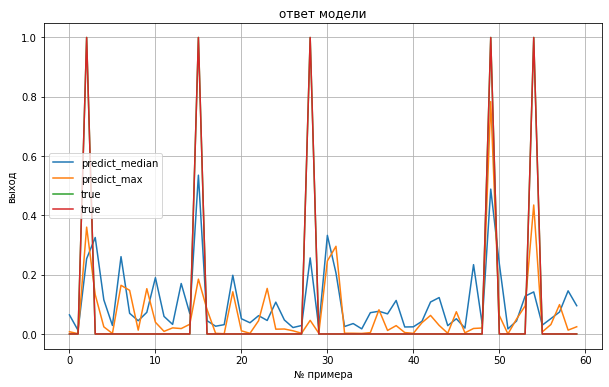

In [53]:
n = 60
plt.figure(figsize=(10, 6))
plt.plot(preds_median[:n], label='predict_median')
plt.plot(preds_max[:n], label='predict_max')
plt.plot(y_median_test.values[:n], label='true')
plt.plot(y_max_test.values[:n], label='true')
plt.title('ответ модели')
plt.xlabel('№ примера')
plt.ylabel('выход')
plt.legend()
plt.grid('On')
plt.show()

In [64]:
#Видим, что по картинке сложно оценить, какая модель max или median лучше справляется с предсказаниями: на части примерах лучше работает max, на другой median.
#Посчитаем интегральную метрику gini и площадь под roc кривой:

fpr_median, tpr_median, tresholds_median = roc_curve(y_median_test.values, preds_median)
fpr_max, tpr_max, tresholds_max = roc_curve(y_max_test.values, preds_max)

roc_auc_median = roc_auc_score(y_median_test.values, preds_median)
roc_auc_max = roc_auc_score(y_max_test.values, preds_max)


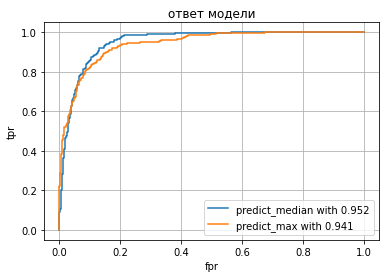

In [68]:
plt.plot(fpr_median, tpr_median, label=f'predict_median with {np.round(roc_auc_median,3)}')
plt.plot(fpr_max, tpr_max, label=f'predict_max with {np.round(roc_auc_max,3)}')
plt.title('ответ модели')
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.legend()
plt.grid('On')
plt.show()

In [79]:
#Видно, что модель с медианными темами для юзеров по метрике gini работает в целом чуть лучше, площадь под roc кривой у медианной модели больше.
#Посмотрим на другие метрики: f1, recall и precision:

precision_median, recall_median, thresholds_median = precision_recall_curve(y_median_test, preds_median)
fscore_median = (2 * precision_median * recall_median) / (precision_median + recall_median)
# locate the index of the largest f score
ix_m = np.argmax(fscore_median)
print(f'Best Threshold for median model={thresholds_median[ix_m]}, F-Score={fscore_median[ix_m]:.3f}, Precision={precision_median[ix_m]:.3f}, Recall={recall_median[ix_m]:.3f}')  

precision_max, recall_max, thresholds_max = precision_recall_curve(y_max_test, preds_max)
fscore_max = (2 * precision_max * recall_max) / (precision_max + recall_max)
# locate the index of the largest f score
ix = np.argmax(fscore_max)
print(f'Best Threshold for max model={thresholds_max[ix]}, F-Score={fscore_max[ix]:.3f}, Precision={precision_max[ix]:.3f}, Recall={recall_max[ix]:.3f}')  

Best Threshold for median model=0.24140522623246508, F-Score=0.693, Precision=0.624, Recall=0.780
Best Threshold for max model=0.28944652260382936, F-Score=0.678, Precision=0.636, Recall=0.727


In [71]:
#По метрике f1-score медианная модель также выигрывает: при почти одинаковых отсечках вероятности, почти равной точности precision, медианной модели удается
#предсказывать с помощью последних прочитанных юзерами новостей больше тех, кто вероятно уйдет по отношению ко всем ушедшим - recall.
#Если посмотреть на матрицу сопряженности для best_treshold для одной и другой модели видно, что медианная выигрывает и по метрике специфичность.
#Можно сказать, что медианная характеристика темы больше отражает юзера, чем максимальная, так как среди прочитанных новостей могут встречаться специфичные (выбросы),
#которые юзера не характеризуют, а значит они будут хуже предсказывать target (ушел/остался). Эта же логика применима и к модели, построенной на основе средних
#характеристик тем: она оказалась хуже по качеству, чем медианна.

In [72]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[1640  115]
 [  55  190]]


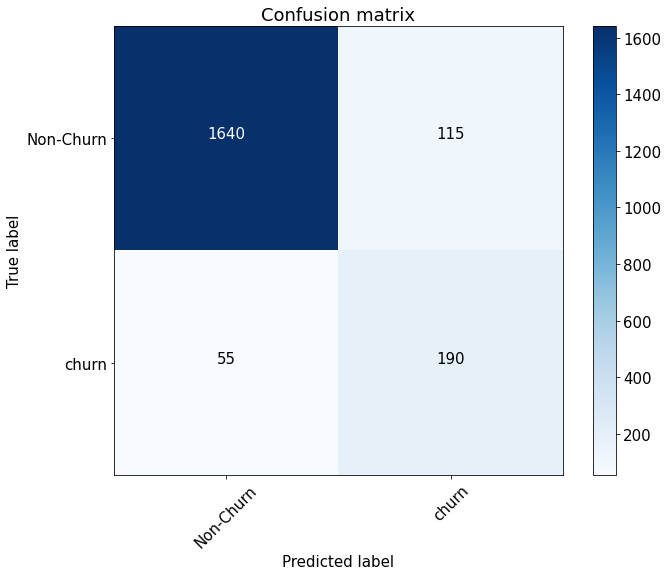

In [75]:
import itertools
# мы уже нашли ранее "оптимальный" порог, когда максимизировали f_score
font = {'size' : 15}

plt.rc('font', **font)

ix = np.argmax(fscore_median)
cnf_matrix_median = confusion_matrix(y_median_test, preds_median > thresholds_median[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_median, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()

Confusion matrix, without normalization
[[1653  102]
 [  68  177]]


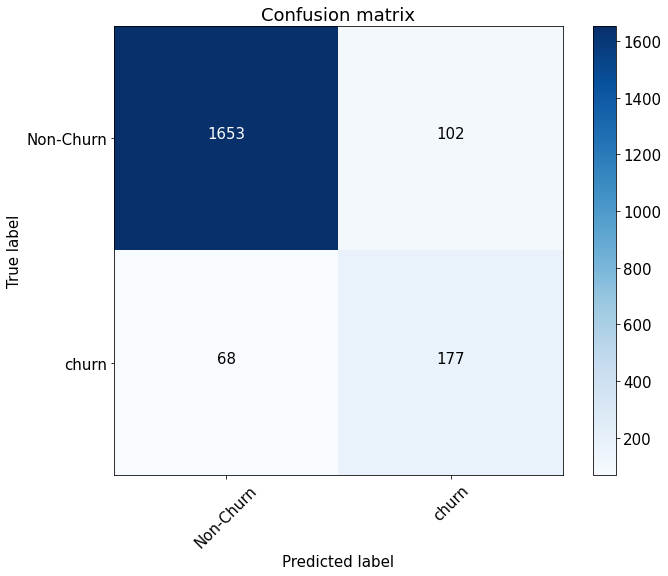

In [77]:
font = {'size' : 15}

plt.rc('font', **font)

ix = np.argmax(fscore_max)
cnf_matrix_max = confusion_matrix(y_max_test, preds_max > thresholds_max[ix])

plt.figure(figsize=(10, 8))
plot_confusion_matrix(cnf_matrix_max, classes=['Non-Churn', 'churn'],
                      title='Confusion matrix')
plt.savefig("conf_matrix.png")
plt.show()